In [2]:
import argparse
import os
import sys
import random
from PIL import Image
import numpy as np
import torch
import glob
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.utils import save_image
from models import TransformerNet, VGG16
#from utils import *

In [11]:
import sys
sys.argv = sys.argv[:1]


In [13]:
from torchvision import transforms

In [3]:
# Mean and standard deviation used for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])


In [4]:
def extract_frames(video_path):
    """ Extracts frames from video """
    frames = []
    video = av.open(video_path)
    for frame in video.decode(0):
        yield frame.to_image()

In [5]:

def gram_matrix(y):
    """ Returns the gram matrix of y (used to compute style loss) """
    (b, c, h, w) = y.size()
    features = y.view(b, c, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (c * h * w)
    return gram

In [6]:
def train_transform(image_size):
    """ Transforms for training images """
    transform = transforms.Compose(
        [
            transforms.Resize(int(image_size * 1.15)),
            transforms.RandomCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
    )
    return transform

In [7]:
def style_transform(image_size=None):
    """ Transforms for style image """
    resize = [transforms.Resize(image_size)] if image_size else []
    transform = transforms.Compose(resize + [transforms.ToTensor(), transforms.Normalize(mean, std)])
    return transform

In [8]:
def denormalize(tensors):
    """ Denormalizes image tensors using mean and std """
    for c in range(3):
        tensors[:, c].mul_(std[c]).add_(mean[c])
    return tensors

In [9]:
def deprocess(image_tensor):
    """ Denormalizes and rescales image tensor """
    image_tensor = denormalize(image_tensor)[0]
    image_tensor *= 255
    image_np = torch.clamp(image_tensor, 0, 255).cpu().numpy().astype(np.uint8)
    image_np = image_np.transpose(1, 2, 0)
    return image_np


In [23]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Parser for Fast-Neural-Style")
   # Set the dataset path to your actual dataset path
    parser.add_argument("--dataset_path", type=str, default="/home/govind/Govind/Bash/Speech-Emotion-Classification-with-PyTorch/STYLE TRANSFER DATASET/content_images", help="path to training dataset")
    parser.add_argument("--style_image", type=str, default="/home/govind/Govind/Bash/code/Fast-Neural-Style-Transfer/images/styles/starry_night.jpg", help="path to style image")
    parser.add_argument("--epochs", type=int, default=1, help="Number of training epochs")
    parser.add_argument("--batch_size", type=int, default=4, help="Batch size for training")
    parser.add_argument("--image_size", type=int, default=256, help="Size of training images")
    parser.add_argument("--style_size", type=int, help="Size of style image")
    parser.add_argument("--lambda_content", type=float, default=1e5, help="Weight for content loss")
    parser.add_argument("--lambda_style", type=float, default=1e10, help="Weight for style loss")
    parser.add_argument("--lr", type=float, default=1e-3, help="Learning rate")
    parser.add_argument("--checkpoint_model", type=str, help="Optional path to checkpoint model")
    parser.add_argument("--checkpoint_interval", type=int, default=2000, help="Batches between saving model")
    parser.add_argument("--sample_interval", type=int, default=1000, help="Batches between saving image samples")
    args = parser.parse_args()

    style_name = args.style_image.split("/")[-1].split(".")[0]
    os.makedirs(f"images/outputs/{style_name}-training", exist_ok=True)
    os.makedirs(f"checkpoints", exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create dataloader for the training data
    train_dataset = datasets.ImageFolder(args.dataset_path, train_transform(args.image_size))
    dataloader = DataLoader(train_dataset, batch_size=args.batch_size)

    # Defines networks
    transformer = TransformerNet().to(device)
    vgg = VGG16(requires_grad=False).to(device)

    # Load checkpoint model if specified
    if args.checkpoint_model:
        transformer.load_state_dict(torch.load(args.checkpoint_model))

    # Define optimizer and loss
    optimizer = Adam(transformer.parameters(), args.lr)
    l2_loss = torch.nn.MSELoss().to(device)

    # Load style image
    style = style_transform(args.style_size)(Image.open(args.style_image))
    style = style.repeat(args.batch_size, 1, 1, 1).to(device)

    # Extract style features
    features_style = vgg(style)
    gram_style = [gram_matrix(y) for y in features_style]

    # Sample 8 images for visual evaluation of the model
    image_samples = []
    image_paths = glob.glob(f"{args.dataset_path}/*/*.jpg")

    if len(image_paths) < 8:
        print("Warning: Not enough images found for sampling. Adjusting the number of samples.")
        num_samples = len(image_paths)
    else:
        num_samples = 8

    for path in random.sample(image_paths, num_samples):
        image_samples += [style_transform(args.image_size)(Image.open(path))]
    image_samples = torch.stack(image_samples)


    def save_sample(batches_done):
        """ Evaluates the model and saves image samples """
        transformer.eval()
        with torch.no_grad():
            output = transformer(image_samples.to(device))
        image_grid = denormalize(torch.cat((image_samples.cpu(), output.cpu()), 2))
        save_image(image_grid, f"images/outputs/{style_name}-training/{batches_done}.jpg", nrow=4)
        transformer.train()

    for epoch in range(args.epochs):
        epoch_metrics = {"content": [], "style": [], "total": []}
        for batch_i, (images, _) in enumerate(dataloader):
            optimizer.zero_grad()

            images_original = images.to(device)
            images_transformed = transformer(images_original)

            # Extract features
            features_original = vgg(images_original)
            features_transformed = vgg(images_transformed)

            # Compute content loss as MSE between features
            content_loss = args.lambda_content * l2_loss(features_transformed.relu2_2, features_original.relu2_2)

            # Compute style loss as MSE between gram matrices
            style_loss = 0
            for ft_y, gm_s in zip(features_transformed, gram_style):
                gm_y = gram_matrix(ft_y)
                style_loss += l2_loss(gm_y, gm_s[: images.size(0), :, :])
            style_loss *= args.lambda_style

            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()

            epoch_metrics["content"] += [content_loss.item()]
            epoch_metrics["style"] += [style_loss.item()]
            epoch_metrics["total"] += [total_loss.item()]

            sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] [Content: %.2f (%.2f) Style: %.2f (%.2f) Total: %.2f (%.2f)]"
                % (
                    epoch + 1,
                    args.epochs,
                    batch_i,
                    len(train_dataset),
                    content_loss.item(),
                    np.mean(epoch_metrics["content"]),
                    style_loss.item(),
                    np.mean(epoch_metrics["style"]),
                    total_loss.item(),
                    np.mean(epoch_metrics["total"]),
                )
            )

            batches_done = epoch * len(dataloader) + batch_i + 1
            if batches_done % args.sample_interval == 0:
                save_sample(batches_done)

            if args.checkpoint_interval > 0 and batches_done % args.checkpoint_interval == 0:
                style_name = os.path.basename(args.style_image).split(".")[0]
                torch.save(transformer.state_dict(), f"checkpoints/{style_name}_{batches_done}.pth")

/home/govind/govindenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/govind/govindenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Epoch 1/1] [Batch 2549/10200] [Content: 1239019.25 (1511483.92) Style: 1021799.62 (857994.85) Total: 2260819.00 (2369478.77)]]]]]

Style IMAGE

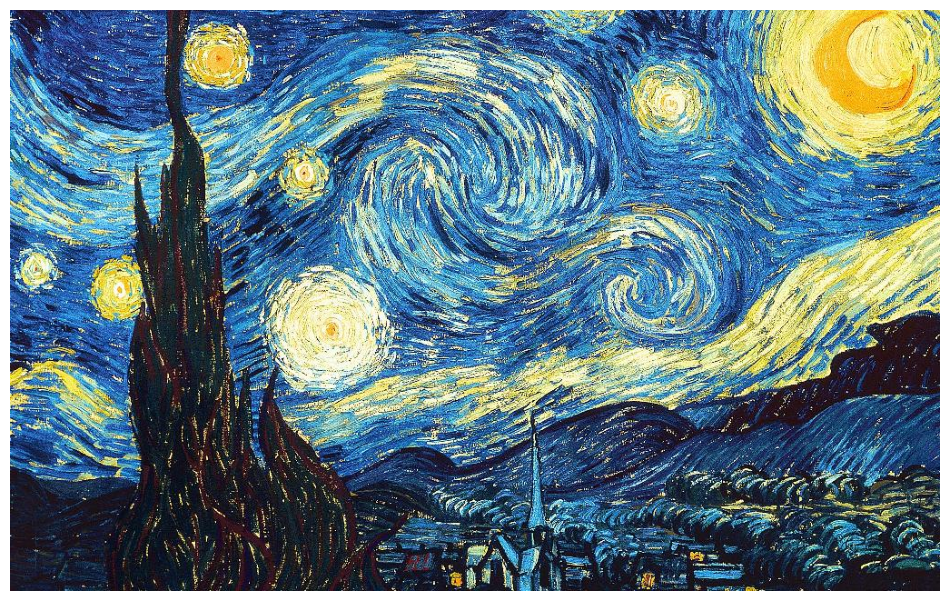

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the path to the image
image_path = '/home/govind/Govind/Bash/code/Fast-Neural-Style-Transfer/images/styles/starry_night.jpg'

# Load the image
img = mpimg.imread(image_path)
# Set a larger figure size
fig, ax = plt.subplots(figsize=(12, 12))


# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

Results

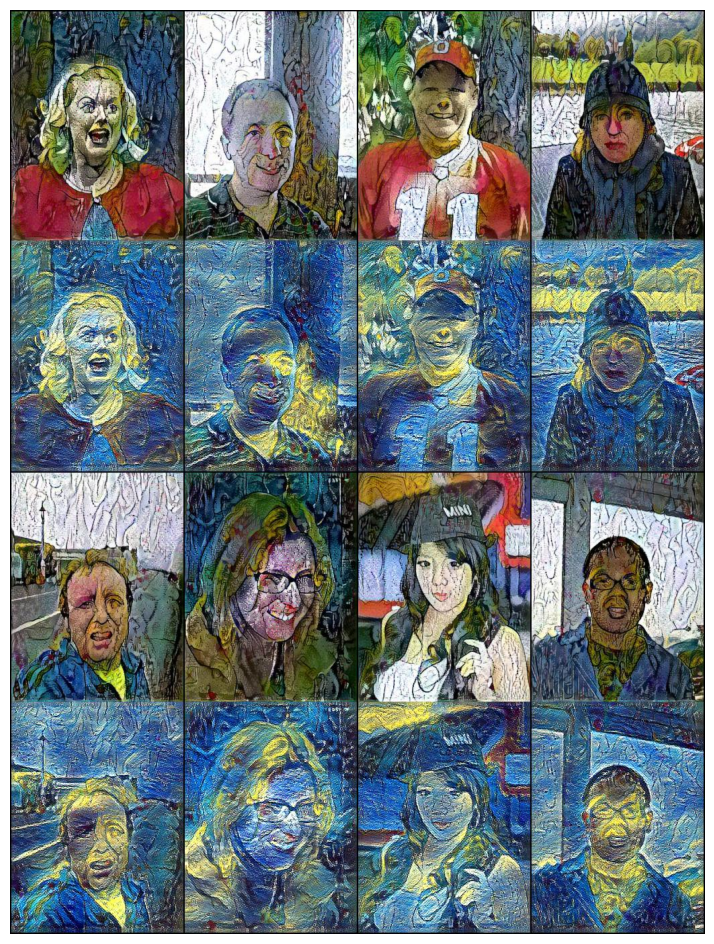

In [25]:
# Define the path to the image
image_path = '/home/govind/Govind/Bash/code/Fast-Neural-Style-Transfer/images/outputs/starry_night-training/2000.jpg'

# Load the image
img = mpimg.imread(image_path)
# Set a larger figure size
fig, ax = plt.subplots(figsize=(12, 12))


# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()


Testing

In [26]:
import tqdm
from torch.autograd import Variable
# Function for testing style transfer
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--image_path", type=str, default = '/home/govind/Govind/Bash/code/Fast-Neural-Style-Transfer/images/content/zurich.jpeg', help="Path to image")
    parser.add_argument("--checkpoint_model", type=str, default = '/home/govind/Govind/Bash/code/Fast-Neural-Style-Transfer/checkpoints/starry_night_2000.pth', help="Path to checkpoint model")
    args = parser.parse_args()
    print(args)

    os.makedirs("images/outputs", exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    transform = style_transform()

    # Define model and load model checkpoint
    transformer = TransformerNet().to(device)
    transformer.load_state_dict(torch.load(args.checkpoint_model))
    transformer.eval()

    # Prepare input
    image_tensor = Variable(transform(Image.open(args.image_path))).to(device)
    image_tensor = image_tensor.unsqueeze(0)

    # Stylize image
    with torch.no_grad():
        stylized_image = denormalize(transformer(image_tensor)).cpu()

    # Save image
    fn = args.image_path.split("/")[-1]
    save_image(stylized_image, f"images/outputs/stylized-{fn}")

Namespace(checkpoint_model='/home/govind/Govind/Bash/code/Fast-Neural-Style-Transfer/checkpoints/starry_night_2000.pth', image_path='/home/govind/Govind/Bash/code/Fast-Neural-Style-Transfer/images/content/zurich.jpeg')


Test Output

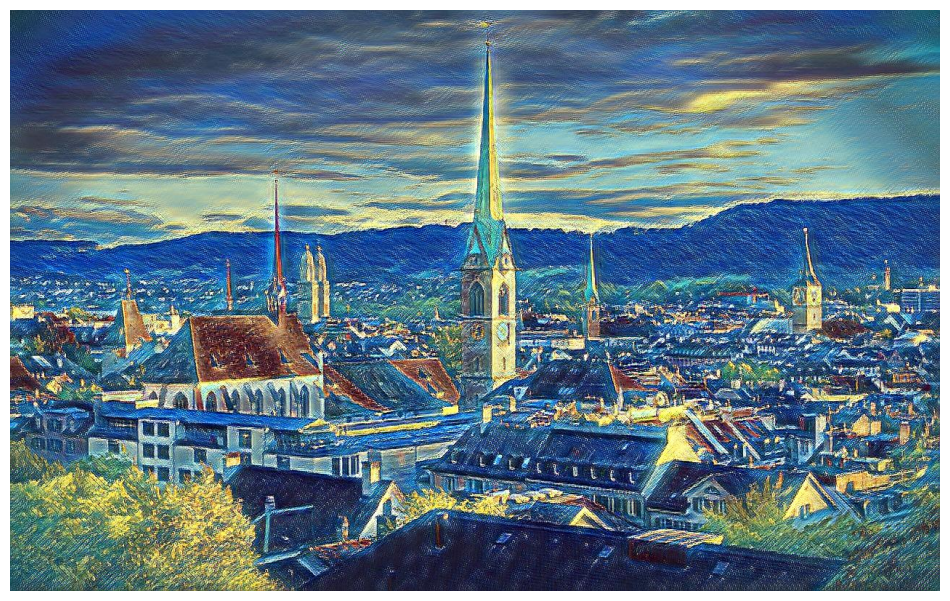

In [27]:
# Define the path to the image
image_path = '/home/govind/Govind/Bash/code/Fast-Neural-Style-Transfer/images/outputs/stylized-zurich.jpeg'

# Load the image
img = mpimg.imread(image_path)
# Set a larger figure size
fig, ax = plt.subplots(figsize=(12, 12))


# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()
